In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, plot_roc_curve

from assignment1.features import update_dataset_features, text_to_binary, add_extra_features

pd.set_option("display.max_columns",500)
plt.style.use('ggplot')

In [2]:
data_path = r"./assignment1/train.csv"

In [3]:
df = pd.read_csv(data_path, sep=";", encoding="utf-8-sig")

In [31]:
#df["claim_date_occured"] = pd.to_datetime(df["claim_date_occured"], format="%Y%m%d")
#min(df["claim_date_occured"].dt.year - df["policy_holder_year_birth"])

# Exploratory Data Analysis (EDA)

In [ ]:
for i in df.columns:
    print(i)
    try:
        df[i].plot(kind="hist")
        plt.show()
        print(df[i].describe())
    except TypeError:
        values = df[i].value_counts()
        if len(values) < 10:
            values.plot(kind="bar")
            plt.show()
            print(df[i].describe())
        else:
            print('*******too many values to plot*******************')
            print(df[i].describe())
    print('*************************************************************************')

In [4]:
df = update_dataset_features(df)

In [5]:
df.isna().sum()

fraud                                 0
claim_liable                          0
claim_num_injured                     0
claim_num_third_parties               0
claim_num_vehicles                    0
claim_police                          0
claim_language                       43
claim_vehicle_type                  154
policy_holder_form                    0
policy_holder_country                 0
policy_num_changes                    0
policy_num_claims                     0
policy_premium_100                 9162
policy_coverage_1000              28420
claim_cause_animal                    0
claim_cause_fire                      0
claim_cause_other                     0
claim_cause_theft                     0
claim_cause_traffic accident          0
claim_cause_vandalism                 0
claim_cause_weather                   0
claim_cause_windows                   0
claim_cause_nan                       0
claim_vehicle_id_count                0
policy_holder_id_count                0


# Base model - off the shelf

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df["fraud"], test_size=.2, random_state=96)

In [20]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
train_lang_mode = X_train["claim_language"].mode()[0]
train_vtype_mode = X_train["claim_vehicle_type"].mode()[0]
X_train["claim_language"].fillna(train_lang_mode, inplace=True)
X_train["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
train_premium_mean = X_train["policy_premium_100"].mean()
train_coverage_mean = X_train["policy_coverage_1000"].mean()
train_policy_holder_mean_age = X_train["policy_holder_age"].mean()
X_train["policy_premium_100"].fillna(train_premium_mean, inplace=True)
X_train["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
X_train["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [21]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [22]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [23]:
# impute remaining missing values with mode or mean from train set on test set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
X_test["claim_language"].fillna(train_lang_mode, inplace=True)
X_test["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
X_test["policy_premium_100"].fillna(train_premium_mean, inplace=True)
X_test["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
X_test["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

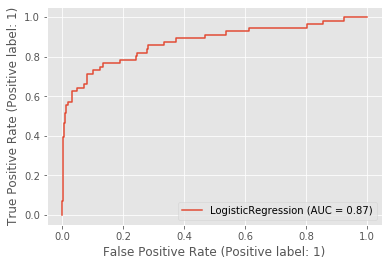

In [24]:
X_test_scaled = scaler.transform(X_test)
plot_roc_curve(clf, X_test_scaled, y_test)

# Submission

In [25]:
submit_path = r"./assignment1/test.csv"

In [26]:
submit_set = pd.read_csv(submit_path, sep=";", encoding="utf-8-sig")

In [27]:
df = submit_set
# convert binary text variables into binary: {"Y":1, "N":0}
for i in ["claim_liable", "claim_police", "driver_injured"]:
    text_to_binary(i, "Y", "N", df)
# {"P":1, "N":0}
text_to_binary("claim_alcohol", "P", "N", df)
# {"car":1, "van":0}
text_to_binary("claim_vehicle_type", "car", "van", df)
# {"M":1, "F":0}
text_to_binary("policy_holder_form", "M", "F", df)
# {"B":1, "N":0}
text_to_binary("policy_holder_country", "B", "N", df)
# make claim_lang binary (currently 1:Dutch, 2:Fr) -> 0: Dutch and 1: French
df["claim_language"] = df["claim_language"] - 1 

# get dummies for cat vars
df = pd.get_dummies(df, dummy_na=True, columns=["claim_cause"])

# format date
YYYYMMDD_date_columns = ["claim_date_registered",
                         "claim_date_occured"]
for i in YYYYMMDD_date_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m%d")

# remove extreme value
df["claim_vehicle_date_inuse"].replace(to_replace=270505.0, value= np.nan, inplace=True)

YYYYMM_columns = ["claim_vehicle_date_inuse", 
                  "policy_date_start",
                  "policy_date_next_expiry",
                  "policy_date_last_renewed"]
for i in YYYYMM_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m")

In [28]:
# Add the extra features just like we did for the training set
df = add_extra_features(df)

In [29]:
# Hide the claim_id column as index so that it's not used as covariate for the prediction, but we can recover
# it later as we need claim_id in the output .csv file
df = df.set_index('claim_id')
df = df[X_train.columns]

In [30]:
df.isna().sum()

claim_liable                          0
claim_num_injured                     0
claim_num_third_parties               0
claim_num_vehicles                    0
claim_police                          0
claim_language                       27
claim_vehicle_type                   69
policy_holder_form                    0
policy_holder_country                 0
policy_num_changes                    0
policy_num_claims                     0
policy_premium_100                 5028
policy_coverage_1000              15291
claim_cause_animal                    0
claim_cause_fire                      0
claim_cause_other                     0
claim_cause_theft                     0
claim_cause_traffic accident          0
claim_cause_vandalism                 0
claim_cause_weather                   0
claim_cause_windows                   0
claim_cause_nan                       0
claim_vehicle_id_count                0
policy_holder_id_count                0
driver_id_count                       0


In [31]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
df["claim_language"].fillna(train_lang_mode, inplace=True)
df["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
df["policy_premium_100"].fillna(train_premium_mean, inplace=True)
df["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
df["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [32]:
assert df.isna().sum().sum() == 0

In [33]:
submit_scaled = scaler.transform(df)

In [34]:
submission = df.reset_index()[['claim_id']]

In [35]:
submission["prediction"] = clf.predict_proba(submit_scaled)[:,1]

In [36]:
submission.columns

Index(['claim_id', 'prediction'], dtype='object')

In [37]:
submission.columns = ["ID", "PROB"]

In [ ]:
submission.to_csv("submission_V0.4.csv", sep=',', index=False)